<a href="https://colab.research.google.com/github/YashMidha/Refact/blob/main/Refact_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Refact using WikiPedia API

## Libraries

In [ ]:
!pip install torch transformers requests beautifulsoup4 spacy pandas seaborn matplotlib scikit-learn datasets google-genai --quiet
!pip install evaluate --quiet
!python -m spacy download en_core_web_sm --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 86.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
import requests
from bs4 import BeautifulSoup
import torch
import spacy
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from datasets import Dataset
import warnings
import gc
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, pipeline
import numpy as np
import evaluate
from sklearn.model_selection import train_test_split

In [ ]:
warnings.filterwarnings("ignore")

## Main

In [ ]:
nlp = spacy.load("en_core_web_sm")
GENERIC_SUBJECTS = ['people', 'it', 'they', 'he', 'she', 'things', 'many', 'some', 'i', 'you', 'we', 'that', 'this']

In [ ]:
def get_cleaned_wiki_text(page_title: str):
    URL = f"https://en.wikipedia.org/w/api.php"
    HEADERS = {'User-Agent': 'MyFactCheckerBot/1.0 (contact@example.com)'}
    PARAMS = {"action": "parse", "page": page_title, "prop": "text", "format": "json", "redirects": ""}
    try:
        response = requests.get(url=URL, params=PARAMS, headers=HEADERS)
        response.raise_for_status()
        data = response.json()
        html_content = data.get("parse", {}).get("text", {}).get("*", "")
        if not html_content: return None
        soup = BeautifulSoup(html_content, 'html.parser')
        for element in soup.find_all(['sup', 'table']): element.decompose()
        return '\n'.join([line.strip() for line in soup.get_text().split('\n') if line.strip()])[:5000]
    except requests.exceptions.RequestException:
        return None

def plot_accuracy_scores(df):
    accuracy_df = df.groupby('model_name')['is_correct'].mean().sort_values(ascending=False) * 100
    plt.figure(figsize=(10, 6)); sns.barplot(x=accuracy_df.index, y=accuracy_df.values, palette='Blues_r')
    plt.title('Overall Model Accuracy Comparison', fontsize=16, pad=20); plt.ylabel('Accuracy (%)', fontsize=12)
    plt.xlabel('Model', fontsize=12); plt.xticks(rotation=15, ha="right"); plt.ylim(0, 100); plt.show()

def plot_category_performance_heatmap(df):
    category_perf = df.groupby(['model_name', 'category'])['is_correct'].mean().unstack() * 100
    plt.figure(figsize=(14, 8)); sns.heatmap(category_perf, annot=True, fmt=".1f", cmap="YlGnBu", linewidths=.5)
    plt.title('Model Accuracy by Sentence Category', fontsize=16, pad=20); plt.xlabel('Sentence Category', fontsize=12)
    plt.ylabel('Model', fontsize=12); plt.show()

def plot_confusion_matrix_for_best_model(df):
    accuracy_df = df.groupby('model_name')['is_correct'].mean();
    if accuracy_df.empty: return
    best_model_name = accuracy_df.idxmax()
    best_model_df = df[df['model_name'] == best_model_name]
    labels = sorted(best_model_df['true_label'].unique())
    cm = confusion_matrix(best_model_df['true_label'], best_model_df['predicted_label'], labels=labels)
    cm_df = pd.DataFrame(cm, index=labels, columns=labels)
    plt.figure(figsize=(8, 6)); sns.heatmap(cm_df, annot=True, fmt='g', cmap='Blues')
    plt.title(f'Confusion Matrix for Best Model: {best_model_name}', fontsize=16, pad=20)
    plt.ylabel('True Label', fontsize=12); plt.xlabel('Predicted Label', fontsize=12); plt.show()


Testing Model: facebook/bart-large-mnli


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Device set to use cuda:0


Map:   0%|          | 0/48 [00:00<?, ? examples/s]


Testing Model: cross-encoder/nli-deberta-v3-large


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.74G [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/301 [00:00<?, ?B/s]

Device set to use cuda:0


Map:   0%|          | 0/48 [00:00<?, ? examples/s]


Testing Model: FacebookAI/roberta-large-mnli


config.json:   0%|          | 0.00/688 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.43G [00:00<?, ?B/s]

Some weights of the model checkpoint at FacebookAI/roberta-large-mnli were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Device set to use cuda:0


Map:   0%|          | 0/48 [00:00<?, ? examples/s]


Testing Model: MoritzLaurer/DeBERTa-v3-base-mnli-fever-anli


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/369M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/23.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/286 [00:00<?, ?B/s]

Device set to use cuda:0


Map:   0%|          | 0/48 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



Testing Model: MoritzLaurer/DeBERTa-v3-large-mnli-fever-anli-ling-wanli


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/870M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/395 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/18.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

Device set to use cuda:0


Map:   0%|          | 0/48 [00:00<?, ? examples/s]



 DETAILED RESULTS
                                            model_name  \
0                             facebook/bart-large-mnli   
1                             facebook/bart-large-mnli   
2                             facebook/bart-large-mnli   
3                             facebook/bart-large-mnli   
4                             facebook/bart-large-mnli   
..                                                 ...   
235  MoritzLaurer/DeBERTa-v3-large-mnli-fever-anli-...   
236  MoritzLaurer/DeBERTa-v3-large-mnli-fever-anli-...   
237  MoritzLaurer/DeBERTa-v3-large-mnli-fever-anli-...   
238  MoritzLaurer/DeBERTa-v3-large-mnli-fever-anli-...   
239  MoritzLaurer/DeBERTa-v3-large-mnli-fever-anli-...   

                                              sentence  true_label  \
0         Vincent van Gogh painted 'The Starry Night'.  entailment   
1         'Hamlet' was written by William Shakespeare.  entailment   
2         The Beatles were a rock band from Liverpool.  entailment   
3  

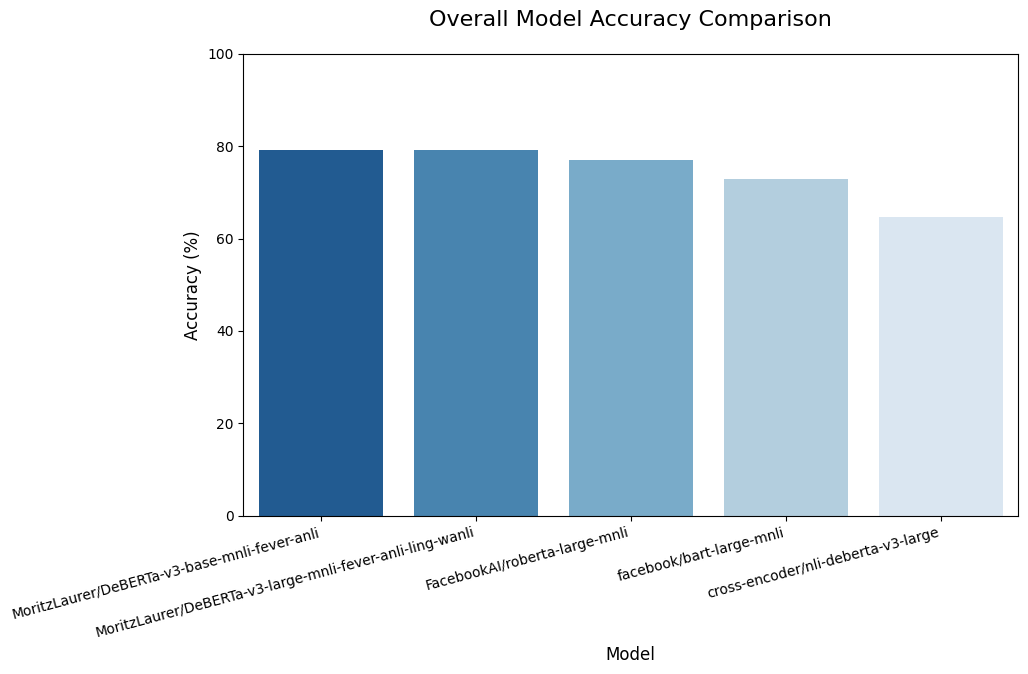

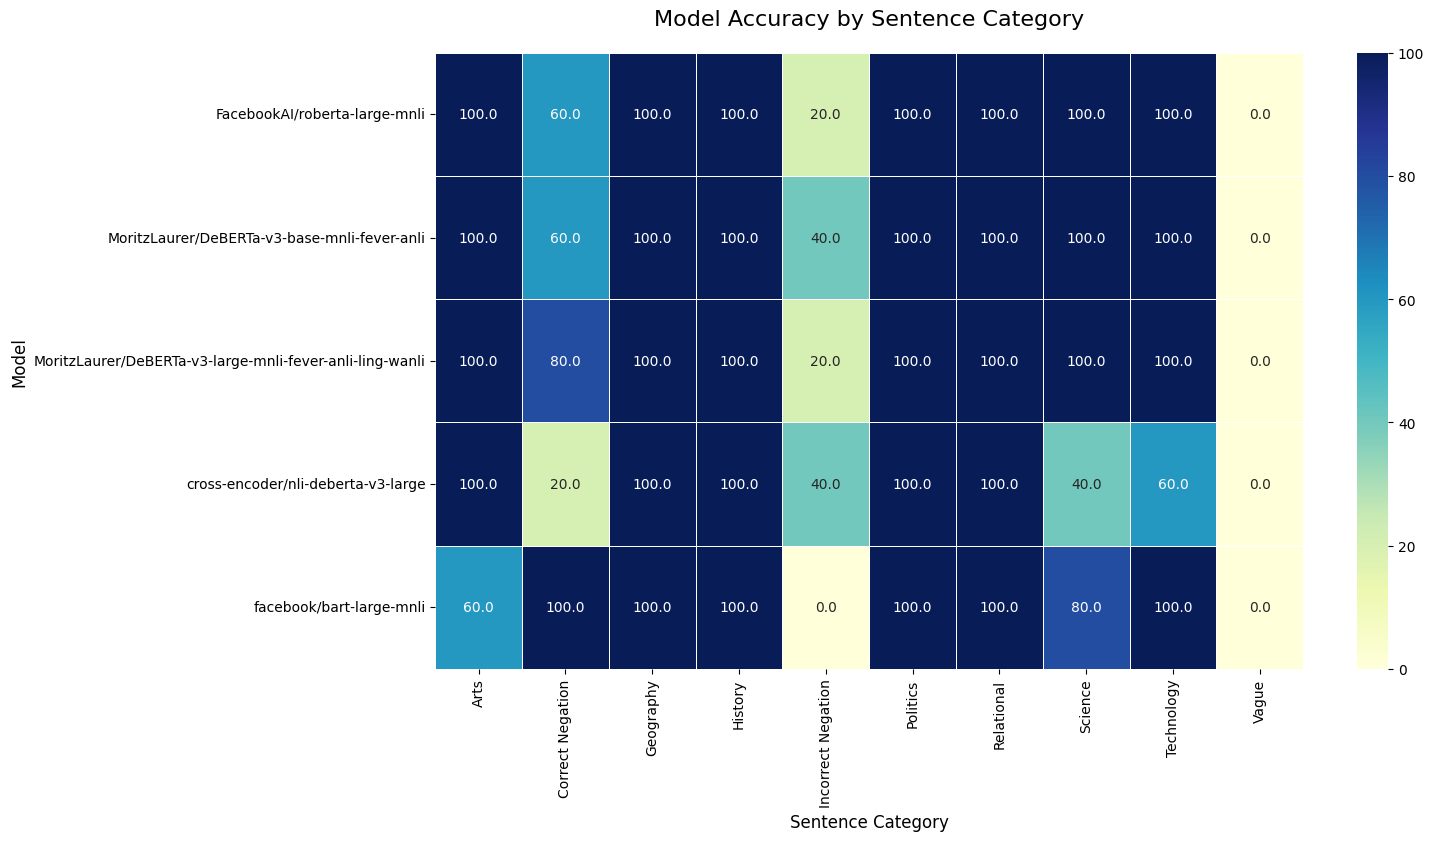

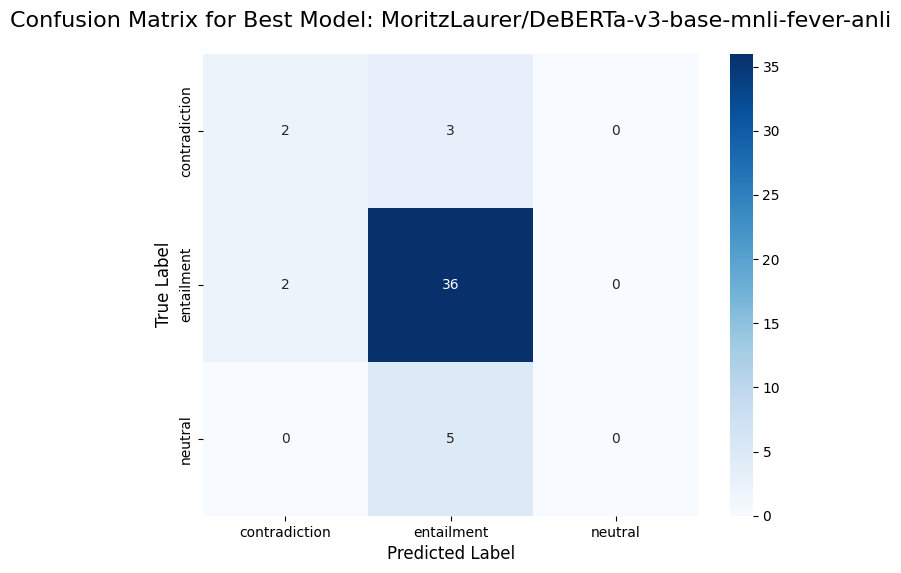

In [ ]:
def run_model_comparison():
    models_to_test = [
        'facebook/bart-large-mnli',
        'cross-encoder/nli-deberta-v3-large',
        'FacebookAI/roberta-large-mnli',
        'MoritzLaurer/DeBERTa-v3-base-mnli-fever-anli',
        'MoritzLaurer/DeBERTa-v3-large-mnli-fever-anli-ling-wanli'
    ]

    extensive_test_suite = [
        # Arts & Culture
        {"sentence": "Vincent van Gogh painted 'The Starry Night'.", "category": "Arts", "true_label": "entailment"},
        {"sentence": "'Hamlet' was written by William Shakespeare.", "category": "Arts", "true_label": "entailment"},
        {"sentence": "The Beatles were a rock band from Liverpool.", "category": "Arts", "true_label": "entailment"},
        {"sentence": "'The Great Gatsby' is a novel by F. Scott Fitzgerald.", "category": "Arts", "true_label": "entailment"},
        {"sentence": "Ludwig van Beethoven composed his Ninth Symphony while he was deaf.", "category": "Arts", "true_label": "entailment"},

        #  Correct Negation
        {"sentence": "Penguins are not mammals.", "category": "Correct Negation", "true_label": "entailment"},
        {"sentence": "The Amazon is not the longest river in Africa.", "category": "Correct Negation", "true_label": "entailment"},
        {"sentence": "A square does not have three sides.", "category": "Correct Negation", "true_label": "entailment"},
        {"sentence": "Mars is not the largest planet in the Solar System.", "category": "Correct Negation", "true_label": "entailment"},
        {"sentence": "Thomas Edison did not invent the telephone.", "category": "Correct Negation", "true_label": "entailment"},

        #  Incorrect Negation
        {"sentence": "Birds are not vertebrates.", "category": "Incorrect Negation", "true_label": "contradiction"},
        {"sentence": "The Pacific Ocean is not the largest ocean on Earth.", "category": "Incorrect Negation", "true_label": "contradiction"},
        {"sentence": "Japan is not an island country.", "category": "Incorrect Negation", "true_label": "contradiction"},
        {"sentence": "The human body does not need water to survive.", "category": "Incorrect Negation", "true_label": "contradiction"},
        {"sentence": "Mount Everest is not in Asia.", "category": "Incorrect Negation", "true_label": "contradiction"},

        #  Geography
        {"sentence": "The capital of Canada is Ottawa.", "category": "Geography", "true_label": "entailment"},
        {"sentence": "The Sahara is the largest hot desert in the world.", "category": "Geography", "true_label": "entailment"},
        {"sentence": "The Amazon River flows through South America.", "category": "Geography", "true_label": "entailment"},
        {"sentence": "Australia is both a continent and a country.", "category": "Geography", "true_label": "entailment"},
        {"sentence": "The Dead Sea is the lowest point on land.", "category": "Geography", "true_label": "entailment"},

        #  History
        {"sentence": "The American Declaration of Independence was signed in 1776.", "category": "History", "true_label": "entailment"},
        {"sentence": "The first man to walk on the Moon was Neil Armstrong.", "category": "History", "true_label": "entailment"},
        {"sentence": "The Roman Empire fell in the 5th century AD.", "category": "History", "true_label": "entailment"},
        {"sentence": "World War I began in 1914.", "category": "History", "true_label": "entailment"},
        {"sentence": "The printing press was invented by Johannes Gutenberg.", "category": "History", "true_label": "entailment"},

        # Politics
        {"sentence": "The United Nations headquarters is located in New York City.", "category": "Politics", "true_label": "entailment"},
        {"sentence": "The Prime Minister is the head of government in the United Kingdom.", "category": "Politics", "true_label": "entailment"},
        {"sentence": "India is the world's largest democracy.", "category": "Politics", "true_label": "entailment"},
        {"sentence": "NATO stands for the North Atlantic Treaty Organization.", "category": "Politics", "true_label": "entailment"},

        #  Relational
        {"sentence": "Queen Victoria was married to Prince Albert.", "category": "Relational", "true_label": "entailment"},
        {"sentence": "The Nile and Amazon rivers are the two longest rivers in the world.", "category": "Relational", "true_label": "entailment"},
        {"sentence": "Microsoft was founded by Bill Gates and Paul Allen.", "category": "Relational", "true_label": "entailment"},
        {"sentence": "The Wright brothers, Orville and Wilbur, are credited with inventing the first successful airplane.", "category": "Relational", "true_label": "entailment"},

        #  Science
        {"sentence": "The speed of light is approximately 299,792 kilometers per second.", "category": "Science", "true_label": "entailment"},
        {"sentence": "Photosynthesis is the process plants use to convert light into chemical energy.", "category": "Science", "true_label": "entailment"},
        {"sentence": "The Earth has one moon.", "category": "Science", "true_label": "entailment"},
        {"sentence": "The chemical formula for table salt is NaCl.", "category": "Science", "true_label": "entailment"},
        {"sentence": "DNA contains the genetic instructions for the development of all known living organisms.", "category": "Science", "true_label": "entailment"},

        #  Technology
        {"sentence": "HTML stands for HyperText Markup Language.", "category": "Technology", "true_label": "entailment"},
        {"sentence": "Linux is an open-source operating system.", "category": "Technology", "true_label": "entailment"},
        {"sentence": "The first iPhone was released by Apple in 2007.", "category": "Technology", "true_label": "entailment"},
        {"sentence": "A CPU is the central processing unit of a computer.", "category": "Technology", "true_label": "entailment"},
        {"sentence": "Wi-Fi uses radio waves to provide wireless high-speed internet.", "category": "Technology", "true_label": "entailment"},

        # Vague
        {"sentence": "Some movies are better than others.", "category": "Vague", "true_label": "neutral"},
        {"sentence": "It is often said that practice makes perfect.", "category": "Vague", "true_label": "neutral"},
        {"sentence": "That was a good decision.", "category": "Vague", "true_label": "neutral"},
        {"sentence": "Many experts agree on the topic.", "category": "Vague", "true_label": "neutral"},
        {"sentence": "Things tend to get better over time.", "category": "Vague", "true_label": "neutral"},
    ]

    prepared_data = []
    for item in extensive_test_suite:
        doc = nlp(item['sentence'])
        topic = None
        noun_chunks = [chunk.text for chunk in doc.noun_chunks]
        if noun_chunks:
            longest_chunk = max(noun_chunks, key=len)
            if longest_chunk.lower() not in GENERIC_SUBJECTS: topic = longest_chunk.strip(".,;")
        context = get_cleaned_wiki_text(topic) if topic else ""
        item['context'] = context if context else ""
        prepared_data.append(item)

    dataset = Dataset.from_list(prepared_data)
    all_results = []
    device = 0 if torch.cuda.is_available() else -1

    for model_name in models_to_test:
        print("\n" + "="*80 + f"\nTesting Model: {model_name}\n" + "="*80)

        nli_pipeline = pipeline('zero-shot-classification', model=model_name, device=device)

        def classify(batch):
          premises = batch['context']
          hypotheses = batch['sentence']
          results = nli_pipeline(
              hypotheses,
              candidate_labels=["entailment", "contradiction", "neutral"],
              hypothesis_template="Based on the context, is it true that {}?",
              context=premises
          )

          if not isinstance(results, list):
              results = [results]
          preds = []
          for res in results:
              best_idx = res['scores'].index(max(res['scores']))
              preds.append(res['labels'][best_idx])
          batch['predicted_label'] = preds
          return batch

        result_dataset = dataset.map(classify, batched=True, batch_size=8)

        for result in result_dataset:
            result['model_name'] = model_name
            all_results.append(result)

        del nli_pipeline; gc.collect();
        if torch.cuda.is_available(): torch.cuda.empty_cache()

    results_df = pd.DataFrame(all_results)
    results_df['is_correct'] = results_df['true_label'] == results_df['predicted_label']

    print("\n\n" + "="*80 + "\n DETAILED RESULTS\n" + "="*80)
    print(results_df[['model_name', 'sentence', 'true_label', 'predicted_label', 'is_correct']])
    agg_results = results_df.groupby('model_name')['is_correct'].mean().reset_index()
    agg_results.columns = ['model_name', 'accuracy']
    print("\n\n" + "="*80 + "\n AGGREGATE ACCURACY\n" + "="*80)
    print(agg_results.sort_values('accuracy', ascending=False))

    print("\n\n" + "="*80 + "\n GENERATING VISUALIZATIONS\n" + "="*80)
    plot_accuracy_scores(results_df)
    plot_category_performance_heatmap(results_df)
    plot_confusion_matrix_for_best_model(results_df)

if __name__ == "__main__":
    run_model_comparison()

## Fine-tuning

In [ ]:
try:
    dataset = load_dataset('csv', data_files='test.csv')
except FileNotFoundError:
    print("\nERROR: csv file not found.")
    exit()

dataset = dataset['train'].train_test_split(test_size=0.2, seed=42)
print("\nDataset loaded and split successfully:")
print(dataset)

model_name = "MoritzLaurer/DeBERTa-v3-base-mnli-fever-anli"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def preprocess_function(examples):
    return tokenizer(examples['premise'], examples['hypothesis'], truncation=True, padding='max_length', max_length=128)

print("\nTokenizing the dataset...")
tokenized_dataset = dataset.map(preprocess_function, batched=True)

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)
accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=4,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    report_to="tensorboard"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

print("\nStarting fine-tuning on your custom dataset...")
trainer.train()

print("\nSaving final model and tokenizer...")
trainer.save_model("my_specialized_model")
tokenizer.save_pretrained("my_specialized_model")



Generating train split: 0 examples [00:00, ? examples/s]


Dataset loaded and split successfully:
DatasetDict({
    train: Dataset({
        features: ['premise', 'hypothesis', 'label'],
        num_rows: 128
    })
    test: Dataset({
        features: ['premise', 'hypothesis', 'label'],
        num_rows: 32
    })
})

Tokenizing the dataset...


Map:   0%|          | 0/128 [00:00<?, ? examples/s]

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 2, 'bos_token_id': 1}.



Starting fine-tuning on your custom dataset...


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.013488,1.000000
2,No log,0.000930,1.000000
3,No log,0.000819,1.000000
4,No log,0.000789,1.000000



Saving final model and tokenizer...


('my_specialized_model/tokenizer_config.json',
 'my_specialized_model/special_tokens_map.json',
 'my_specialized_model/spm.model',
 'my_specialized_model/added_tokens.json',
 'my_specialized_model/tokenizer.json')

## Test on fine-tuning

In [ ]:

print("\nEvaluating the final fine-tuned model")
final_evaluation = trainer.evaluate()

print("\nFine-Tuning Complete")
print(f"Final Test Accuracy on custom data: {final_evaluation['eval_accuracy'] * 100:.2f}%")

print("\n" + "="*50)
print("="*50)

device = "cuda" if torch.cuda.is_available() else "cpu"
tokenizer = AutoTokenizer.from_pretrained("my_specialized_model")
model = AutoModelForSequenceClassification.from_pretrained("my_specialized_model").to(device)
nlp = spacy.load("en_core_web_sm")

label_map = {0: "entailment", 1: "neutral", 2: "contradiction"}


def check_question(question: str):
    print(f"\nVerifying: '{question}'")
    doc = nlp(question)
    noun_chunks = [chunk.text for chunk in doc.noun_chunks]
    topic = max(noun_chunks, key=len) if noun_chunks else None

    if not topic:
        print("  - Verdict: Uncertain (Could not find a topic)")
        return

    print(topic)

    context = get_cleaned_wiki_text(topic)
    if not context:
        print(f"  - Verdict: Uncertain (Could not find context for '{topic}')")
        return

    inputs = tokenizer(context, question, return_tensors="pt", truncation=True, padding=True).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        pred_id = torch.argmax(logits, dim=-1).item()
        confidence = torch.softmax(logits, dim=-1)[0][pred_id].item()

    verdict = label_map.get(pred_id, "Unknown")
    print(f"  - Verdict: {verdict.title()} (Confidence: {confidence:.2%})")

questions_to_test = [
    "Penguins are not mammals.",
    "The Pacific Ocean is not the largest ocean on Earth.",
    "The Pacific Ocean is the largest ocean on Earth.",
    "Learning a new language is fun.",
    "The sun does not revolve around the Earth.",
    "The earth revolve around the sun"
]

for q in questions_to_test:
    check_question(q)


Evaluating the final fine-tuned model



Fine-Tuning Complete
Final Test Accuracy on custom data: 100.00%


Verifying: 'Penguins are not mammals.'
Penguins


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


  - Verdict: Entailment (Confidence: 98.74%)

Verifying: 'The Pacific Ocean is not the largest ocean on Earth.'
The Pacific Ocean
  - Verdict: Entailment (Confidence: 90.58%)

Verifying: 'The Pacific Ocean is the largest ocean on Earth.'
The Pacific Ocean
  - Verdict: Neutral (Confidence: 48.44%)

Verifying: 'Learning a new language is fun.'
a new language
  - Verdict: Uncertain (Could not find context for 'a new language')

Verifying: 'The sun does not revolve around the Earth.'
the Earth
  - Verdict: Entailment (Confidence: 97.92%)

Verifying: 'The earth revolve around the sun'
The earth
  - Verdict: Entailment (Confidence: 88.24%)


In [ ]:
from google.colab import userdata
from google import genai
from google.genai.errors import APIError
GEMINI_API_KEY = userdata.get('GOOGLE_API_KEY')
client = genai.Client(api_key=GEMINI_API_KEY)

In [ ]:
def get_gemini_answer(prompt: str) -> str:
    try:
        response = client.models.generate_content(
            model='gemini-2.5-flash',
            contents=prompt,
            config=genai.types.GenerateContentConfig(
                temperature=0.0
            )
        )
        return response.text.strip()
    except APIError as e:
        print(f"Gemini API Error: {e}")
        return "An error occurred while generating the answer."
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return "An unexpected error occurred while generating the answer."

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

try:
    tokenizer = AutoTokenizer.from_pretrained("my_specialized_model")
    model = AutoModelForSequenceClassification.from_pretrained("my_specialized_model").to(device)
    nli_ready = True
except Exception as e:
    print(f"Could not load NLI model 'my_specialized_model'")
    nli_ready = False

label_map = {0: "entailment", 1: "neutral", 2: "contradiction"}

In [ ]:
def check_sentence(sentence: str):
    if not nli_ready:
        print(f"  - NLI Model Not Loaded. Skipping check for: '{sentence}'")
        return None, None

    doc = nlp(sentence)
    noun_chunks = [chunk.text.strip(".,;") for chunk in doc.noun_chunks]

    topic = next((c for c in sorted(noun_chunks, key=len, reverse=True) if c.lower() not in GENERIC_SUBJECTS), None)

    if not topic:
        return "Uncertain", f"Could not find a specific topic in the sentence."

    context = get_cleaned_wiki_text(topic)
    if not context:
        return "Uncertain", f"Could not find context for topic: '{topic}'"

    inputs = tokenizer(context, sentence, return_tensors="pt", truncation=True, padding=True).to(device)

    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        pred_id = torch.argmax(logits, dim=-1).item()
        confidence = torch.softmax(logits, dim=-1)[0][pred_id].item()

    verdict = label_map.get(pred_id, "Unknown")

    hallucination_verdict = ""
    if verdict == "contradiction":
        hallucination_verdict = f"Hallucination (Contradiction: {confidence:.2%})"
    elif verdict == "neutral":
        hallucination_verdict = f"Possible Hallucination (Neutral: {confidence:.2%})"
    else:
        hallucination_verdict = f"Supported (Entailment: {confidence:.2%})"

    return hallucination_verdict, f"Topic: '{topic}' | Context from Wiki: '{context[:100]}...'"

In [ ]:
def evaluate_gemini_answer_for_hallucination(user_prompt: str):
    print(f"HALLUCINATION DETECTION FOR PROMPT: '{user_prompt}'")

    gemini_answer = get_gemini_answer(user_prompt)

    print("Answer by Gemini:-")
    print(gemini_answer)

    doc = nlp(gemini_answer)
    sentences = [sent.text.strip() for sent in doc.sents if sent.text.strip()]

    if not sentences:
        print("No sentences found in the answer to evaluate.")
        return

    print("Sentence-by-Sentence Hallucination Evaluation")

    results = []
    for i, sentence in enumerate(sentences):
        print(f"\n[Sentence {i+1}/{len(sentences)}]: {sentence}")
        verdict, details = check_sentence(sentence)

        if verdict:
            print(f"  => VERDICT: {verdict}")
            if details:
                 print(f"    Details: {details}")

        results.append({
            "sentence": sentence,
            "verdict": verdict,
            "details": details
        })


    hallucinations = [r for r in results if r['verdict'] and 'Hallucination' in r['verdict']]
    if hallucinations:
        print(f"Found {len(hallucinations)} potential hallucinations in the answer.")
    else:
        print("No factual hallucinations (contradictions) detected.")

In [ ]:
prompts_to_test = [
    "Where does the sun rise from?",
    "Which is the fastest animal?"
]

if __name__ == "__main__":
    for prompt in prompts_to_test:
        evaluate_gemini_answer_for_hallucination(prompt)

HALLUCINATION DETECTION FOR PROMPT: 'Where does the sun rise from?'
Answer by Gemini:-
The sun rises in the **East**.

This is due to the Earth's rotation. As the Earth spins on its axis, it rotates from west to east, making the sun appear to move across the sky from east to west.

While it's always generally in the East, the *exact* point on the horizon can shift slightly throughout the year due to the Earth's tilt and its orbit around the sun:

*   On the spring and autumn equinoxes, it rises precisely due East.
*   In the summer, it rises slightly north of East.
*   In the winter, it rises slightly south of East.
Sentence-by-Sentence Hallucination Evaluation

[Sentence 1/9]: The sun rises in the **East**.
  => VERDICT: Supported (Entailment: 90.68%)
    Details: Topic: 'The sun' | Context from Wiki: 'Star at the centre of the Solar System
"The Sun" redirects here. For other uses, see Sun (disambigua...'

[Sentence 2/9]: This is due to the Earth's rotation.
  => VERDICT: Uncertain
  